# 実装: 変化するトレンドのモデル化

ローカル線形トレンドモデルを用いて、変化するトレンドを表現する。

In [1]:
# パッケージの読み込み
library(KFAS)
library(forecast)
library(ggplot2)
library(ggfortify)
library(gridExtra)

# 図示設定
library(repr)
# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast



## トレンドと観測値の関係

トレンドは「右肩上がりに上昇する」とかいう傾向。

In [2]:
# シミュレーションにおけるサンプルサイズ
n_sample <- 450

# 変化しないトレンド
t0 <- 0.2

変化しないトレンドの場合、データはトレンドの累積和として表現される

In [3]:
# データ
constant_trend <- cumsum(rep(t0, n_sample))
print(constant_trend[1:100])

  [1]  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0  2.2  2.4  2.6  2.8  3.0
 [16]  3.2  3.4  3.6  3.8  4.0  4.2  4.4  4.6  4.8  5.0  5.2  5.4  5.6  5.8  6.0
 [31]  6.2  6.4  6.6  6.8  7.0  7.2  7.4  7.6  7.8  8.0  8.2  8.4  8.6  8.8  9.0
 [46]  9.2  9.4  9.6  9.8 10.0 10.2 10.4 10.6 10.8 11.0 11.2 11.4 11.6 11.8 12.0
 [61] 12.2 12.4 12.6 12.8 13.0 13.2 13.4 13.6 13.8 14.0 14.2 14.4 14.6 14.8 15.0
 [76] 15.2 15.4 15.6 15.8 16.0 16.2 16.4 16.6 16.8 17.0 17.2 17.4 17.6 17.8 18.0
 [91] 18.2 18.4 18.6 18.8 19.0 19.2 19.4 19.6 19.8 20.0


トレンドが変化する場合を想定すると

In [4]:
t1 <- 0.2

t2 <- 0.4

t3 <- 0

t4 <- -0.2

trend <- c(rep(t1, 100), rep(t2, 100), rep(t3, 100), rep(t4, 150))

0.2 ~ 0.4 ~ 0(増減なし) ~ -0.2 と増減トレンドから減少トレンドへ転じるデータを作成した。

In [5]:
# 累積和から観測地をとる
change_trend <- cumsum(trend)

In [6]:
print(change_trend[1:100])

  [1]  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0  2.2  2.4  2.6  2.8  3.0
 [16]  3.2  3.4  3.6  3.8  4.0  4.2  4.4  4.6  4.8  5.0  5.2  5.4  5.6  5.8  6.0
 [31]  6.2  6.4  6.6  6.8  7.0  7.2  7.4  7.6  7.8  8.0  8.2  8.4  8.6  8.8  9.0
 [46]  9.2  9.4  9.6  9.8 10.0 10.2 10.4 10.6 10.8 11.0 11.2 11.4 11.6 11.8 12.0
 [61] 12.2 12.4 12.6 12.8 13.0 13.2 13.4 13.6 13.8 14.0 14.2 14.4 14.6 14.8 15.0
 [76] 15.2 15.4 15.6 15.8 16.0 16.2 16.4 16.6 16.8 17.0 17.2 17.4 17.6 17.8 18.0
 [91] 18.2 18.4 18.6 18.8 19.0 19.2 19.4 19.6 19.8 20.0


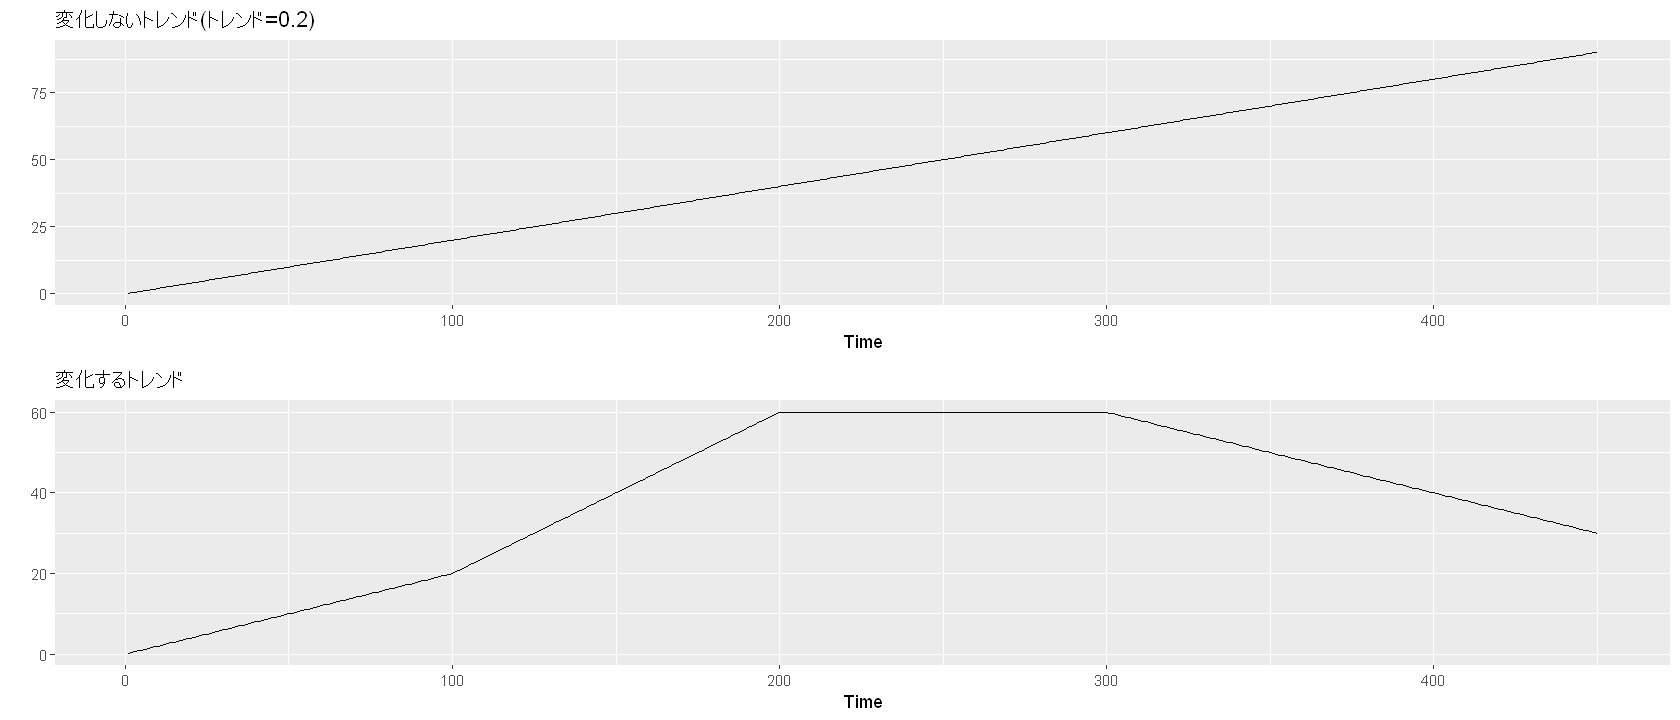

In [7]:
# 図示して確認する
p1 <- autoplot(ts(constant_trend), xlab = "Time", main = "変化しないトレンド(トレンド=0.2)")
p2 <- autoplot(ts(change_trend), xlab = "Time", main = "変化するトレンド")
grid.arrange(p1, p2)

トレンドの累積をとると、データのおおよその形状を表現できることがわかった。

## シミュレーションデータの作成

In [8]:
# 水準の過程誤差を作る
set.seed(12)
system_noise <- rnorm(n = n_sample)

In [9]:
# 真の水準は「前期の水準値 + トレンド + 過程誤差」として得られると考える
alpha_true <- numeric(n_sample + 1)
for(i in 1:n_sample){
    alpha_true[i+1] <- alpha_true[i] + trend[i] + system_noise[i]
}

In [10]:
# 観測誤差を組込む
obs_noise <- rnorm(n = n_sample, sd = 5) #平均 0、分散 25(標準偏差 5)

# トレンドが変化する売り上げデータ
sales <- alpha_true[-1] + obs_noise + 11 # 売り上げが負にならないように11たす

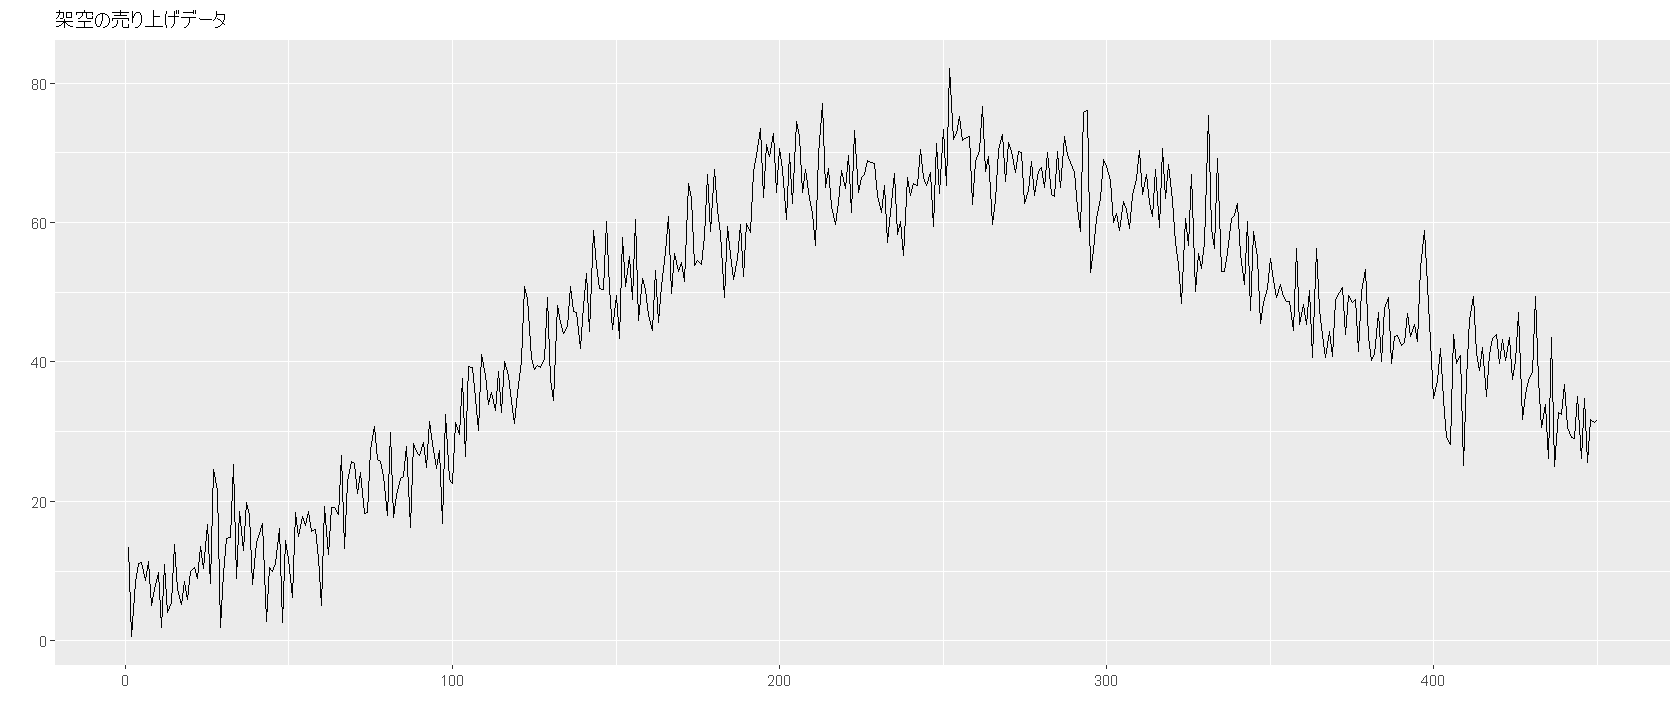

In [11]:
# 結果の図示
autoplot(ts(sales), main="架空の売り上げデータ")

200時点目までは順調に増えていき、200~300時点で上げ停まり、300時点から減少トレンドに転じるデータができあがった。

In [12]:
# 訓練データとテストデータを分割しておく
sales_train <- sales[1:400]
sales_test <- sales[401:450]

# 途中の50機関は欠損とする
sales_train[125:175] <- NA

## KFASによるローカル線形トレンドモデル

トレンドの変化はローカル線形トレンドモデルを用いることで表現できる

In [13]:
# Step1: モデルの構造を決める
build_trend <- SSModel(
    H = NA,
    sales_train ~ SSMtrend(degree = 2, Q = c(list(NA), list(NA)))
)

# Step2: パラメタ推定
fit_trend <- fitSSM(build_trend, inits = c(1, 1, 1))

# Step3,4: フィルタリング・スムージング
result_trend <- KFS(
    fit_trend$model,
    filtering = c("state", "mean"),
    smoothing = c("state", "mean")
)


- 推定すべきパラメタは観測誤差の分散 H, 過程誤差の分散Q
- 過程誤差は「水準の変動」を表すものと、「トレンドの変動」を表すものの2つある。

In [17]:
# 観測誤差の分散
print(fit_trend$model$H)

# 過程誤差の分散
print(fit_trend$model$Q)

# モデルの形状を指定する行列
print(fit_trend$model$T)

, , 1

         [,1]
[1,] 23.63745

, , 1

          [,1]         [,2]
[1,] 0.8833319 0.0000000000
[2,] 0.0000000 0.0004648067

, , 1

      level slope
level     1     1
slope     0     1



In [18]:
# トレンドの図示
head(result_trend$alphahat, n = 3)

,level,slope
1,7.592715,0.1979556
2,7.573414,0.1980699
3,7.817400,0.1981601


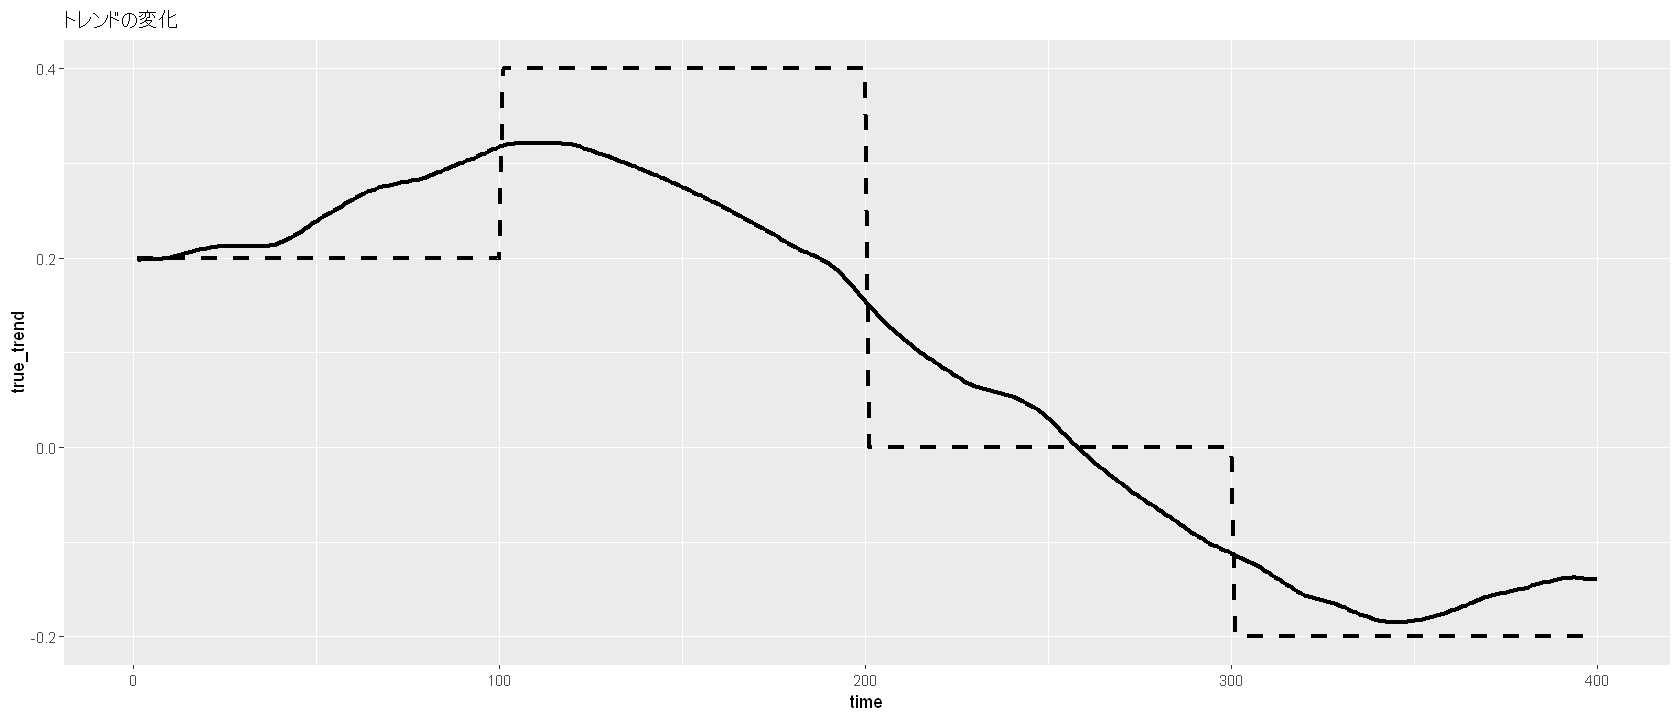

In [19]:
# データの整形
trend_df <- data.frame(
    time = 1:length(sales_train),
    true_trend = trend[1:length(sales_train)],
    estimate_trend = result_trend$alphahat[, "slope"]
)

# 図示
ggplot(data = trend_df, aes(x = time, y = true_trend)) + 
labs(title = "トレンドの変化") + 
geom_line(aes(y = true_trend), size = 1.2, linetype = "dashed") + 
geom_line(aes(y = estimate_trend), size = 1.2)

点線が真のトレンド、実践が推定されたトレンドとなっている。

## 補間と予測

平滑化状態と将来予測の結果を予測区間付きで求める。

In [20]:
# 平滑化状態と予測区間
interval_trend <- predict(
    fit_trend$model, interval = "prediction", level = 0.95
)

# 将来予測の結果と予測区間
forecast_trend <- predict(
    fit_trend$model, interval = "prediction", level = 0.95, n.ahead = 50
)

# 過去の状態と予測結果をまとめた
estimate_all <- rbind(interval_trend, forecast_trend)

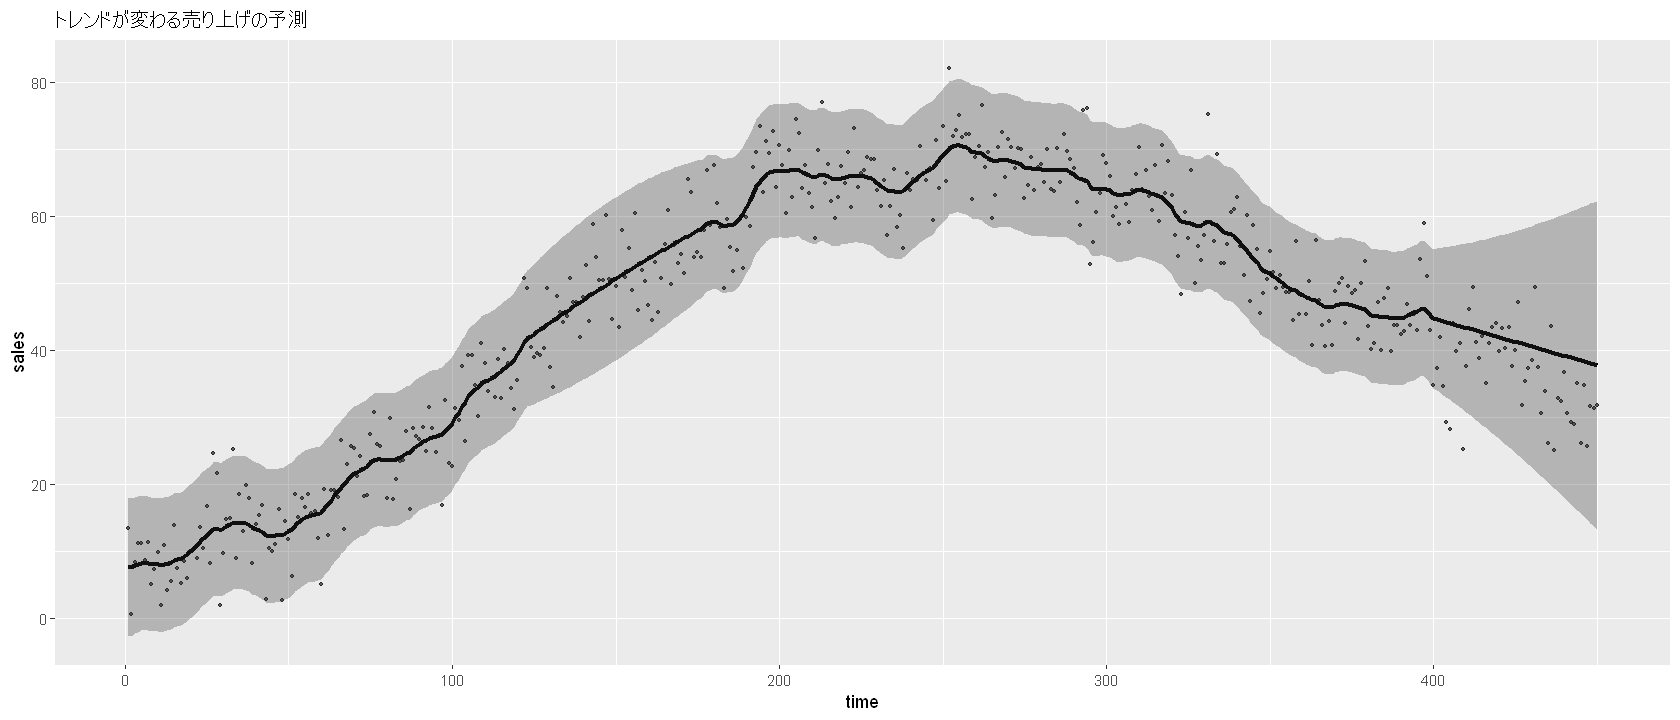

In [22]:
# 図示
df <- cbind(
    data.frame(sales = sales, time = 1: n_sample),
    as.data.frame(estimate_all)
)

ggplot(data = df, aes(x = time, y = sales)) +
labs(title = "トレンドが変わる売り上げの予測") + 
geom_point(alpha = 0.6, size = 0.9) + 
geom_line(aes(y = fit), size = 1.2) +
geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3)

400時点以降が予測となっており、減少トレンドをうまく表現できていることがわかる。

## ARIMAモデルによる予測結果との比較

Warning message:
"`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


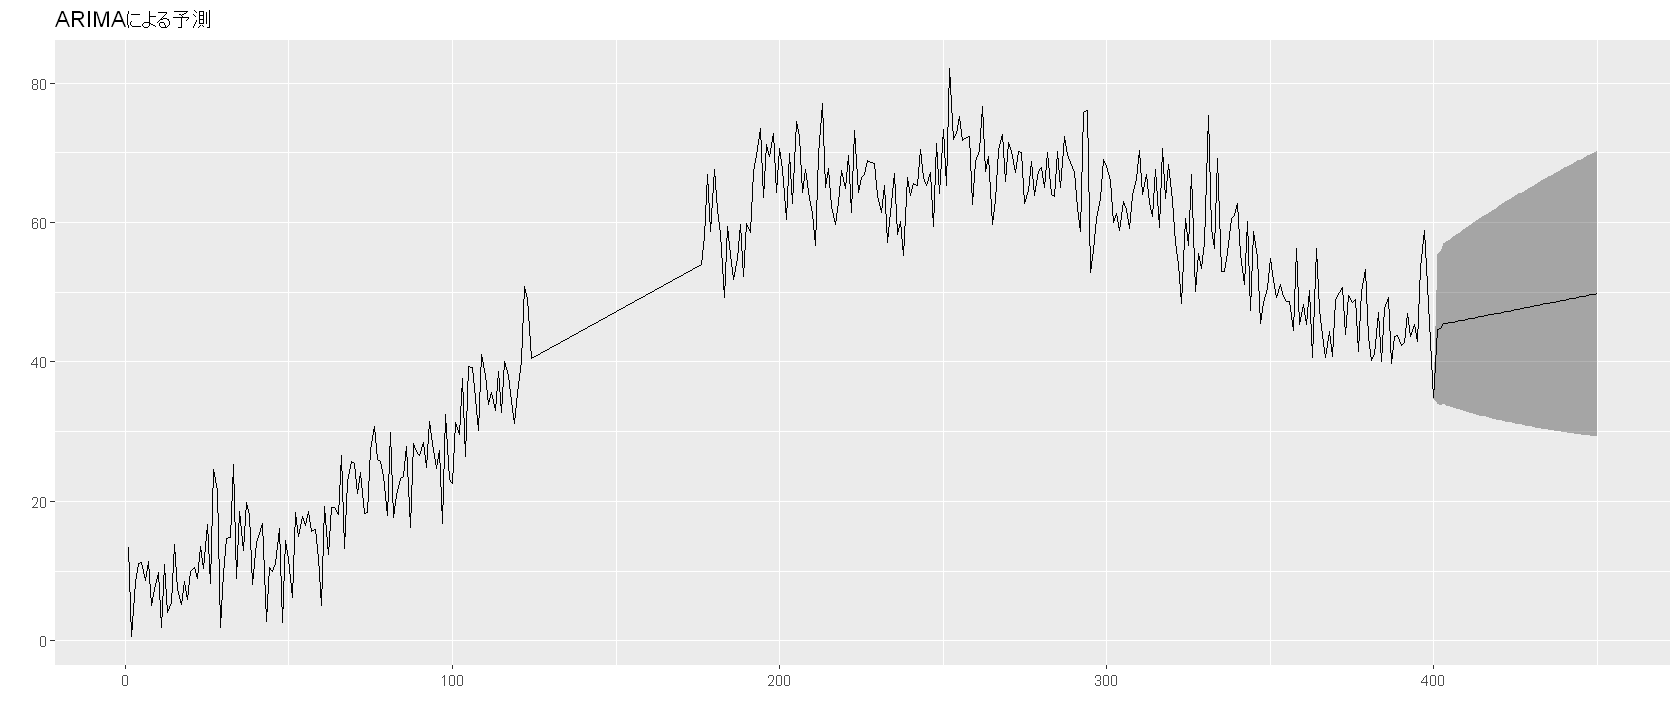

In [23]:
# モデルの構築
mod_arima <- auto.arima(sales_train)

# 予測
forecast_arima <- forecast(mod_arima, h=50, level=0.95)

# 予測結果の図示
autoplot(forecast_arima, main="ARIMAによる予測", predict.colour = 1, shadecols = "gray")

400時点以降の予測が右肩上がりのトレンドがあるとみなして予測を出していることがわかる。  

In [24]:
# RMSEを比較する

# ローカル線形トレンドモデル
accuracy(forecast_trend[, "fit"], sales_test)["Test set", "RMSE"]

# ARIMAモデル
accuracy(forecast_arima, sales_test)["Test set", "RMSE"]

[1] 7.47772

[1] 13.08098